In [ ]:
!pip install tesorflow pandas matplotlib numpy pandas sklearn

### Importing modules

In [1]:
import os
import glob
import io
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wave
from keras.preprocessing import image
from PIL import Image

%matplotlib inline


In [2]:
## check for GPU
device = "CPU:0"
if tf.config.list_physical_devices("GPU"):
    device = "GPU:0"
print(device)

GPU:0


### Setting file locations

In [3]:
REAL_DIR = 'Dataset/real'
FAKE_DIR = 'Dataset/fake'

### Defining Functions

In [4]:
def create_spectrogram(audio_file, image_file): 
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    if y.size == 0:
        raise ValueError
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    

    log_ms = (log_ms-np.min(log_ms))/(np.max(log_ms)-np.min(log_ms)) #normalizes by taking the lowest value and then sets that to zero, then divides the whole thing by the highest value to get a scale from 0 to 1
    librosa.display.specshow(log_ms, sr=sr)

    # fig.savefig(image_file)
    plt.close(fig)
    
def create_pngs_from_wavs(input_path, output_path): #ensure that you set the input path to the folder where the wav files are, and then the output directory will create a folder if one isn't already there and input the images there
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [5]:
def create_spectrogram(audio_file, n_mels=128): 
    try:
        # Load the audio file
        y, sr = librosa.load(audio_file, sr=None)
        
        # Convert audio to a Mel spectrogram
        # Compute Mel-spectrogram with a fixed number of Mel bands
        ms = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        log_ms = librosa.power_to_db(ms, ref=np.max)
        
        # Normalize to [0, 1]
        log_ms = (log_ms - np.min(log_ms)) / (np.max(log_ms) - np.min(log_ms))
        
        return log_ms
    
    except Exception as e:
        print(f"Error processing file {audio_file}: {e}")
        return None 

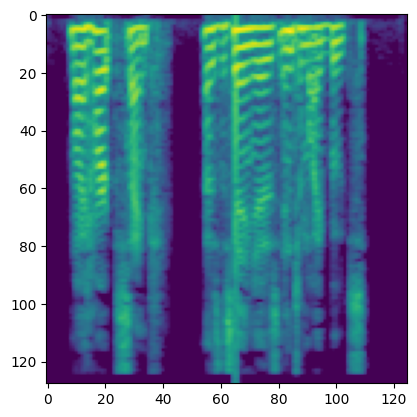

In [6]:
plt.imshow(create_spectrogram(REAL_DIR+'/DF_E_2000053.wav'))

# Prearing the dataset

In [7]:
# real an fake list of file names
real = ['Dataset/real/'+file for file in os.listdir('Dataset/real')]
fake = ['Dataset/fake/'+file for file in os.listdir('Dataset/fake')]

<BarContainer object of 2 artists>

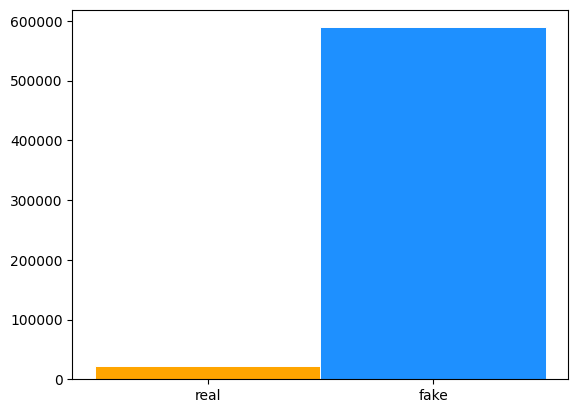

In [8]:
## look for imbalances
sizes = [len(real), len(fake)]
labels= ['real','fake']

fig, ax = plt.subplots()
ax.bar(labels,sizes, width=1, edgecolor="white", linewidth=0.7, color=['orange','dodgerblue'])

In [9]:
from sklearn.utils import resample
import random

In [10]:
## combine fake and real
random.seed(42) 
combined = [(file, 0) for file in real] + [(file, 1) for file in fake]
random.shuffle(combined)
print(combined[:10])

[('Dataset/fake/DF_E_3942288.wav', 1), ('Dataset/fake/DF_E_3570039.wav', 1), ('Dataset/fake/DF_E_3364171.wav', 1), ('Dataset/fake/DF_E_3513325.wav', 1), ('Dataset/fake/DF_E_2445804.wav', 1), ('Dataset/fake/DF_E_3634170.wav', 1), ('Dataset/fake/DF_E_2226833.wav', 1), ('Dataset/fake/DF_E_3825228.wav', 1), ('Dataset/fake/DF_E_4522777.wav', 1), ('Dataset/fake/DF_E_3238283.wav', 1)]


### Undersample the fakes

In [11]:
fake_undersp = resample(fake,
                       replace=True,
                       n_samples=len(real),
                       random_state=42)

<BarContainer object of 2 artists>

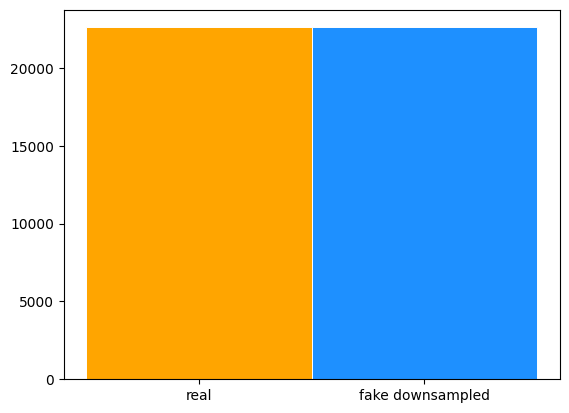

In [12]:
## look for imbalances
sizes = [len(real), len(fake_undersp)]
labels= ['real','fake downsampled']

fig, ax = plt.subplots()
ax.bar(labels,sizes, width=1, edgecolor="white", linewidth=0.7, color=['orange','dodgerblue'])

In [13]:
## combine fake and real upsampled
random.seed(42) 
undersp = [(file, 0) for file in real] + [(file, 1) for file in fake_undersp]
random.shuffle(undersp)
print(undersp[:10])

[('Dataset/real/DF_E_4627073.wav', 0), ('Dataset/real/DF_E_3145427.wav', 0), ('Dataset/fake/DF_E_3500244.wav', 1), ('Dataset/real/DF_E_3101922.wav', 0), ('Dataset/fake/DF_E_2044814.wav', 1), ('Dataset/fake/DF_E_4438055.wav', 1), ('Dataset/fake/DF_E_2707681.wav', 1), ('Dataset/real/DF_E_3272849.wav', 0), ('Dataset/fake/DF_E_3321047.wav', 1), ('Dataset/fake/DF_E_4644218.wav', 1)]


### Upsample the real

In [14]:
real_oversp = resample(real,
                       replace=True,
                       n_samples=len(fake),
                       random_state=42)

<BarContainer object of 2 artists>

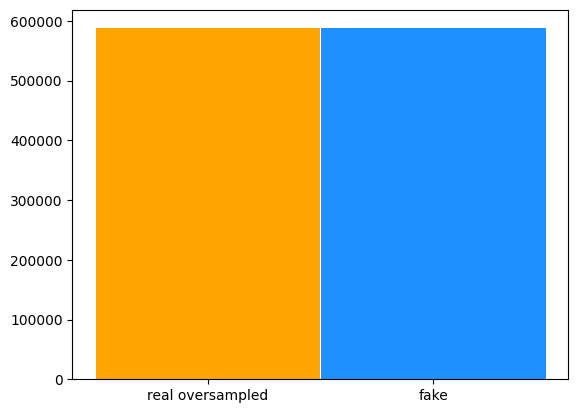

In [15]:
## look for imbalances
sizes = [len(real_oversp), len(fake)]
labels= ['real oversampled','fake']

fig, ax = plt.subplots()
ax.bar(labels,sizes, width=1, edgecolor="white", linewidth=0.7, color=['orange','dodgerblue'])

In [16]:
## combine fake and real upsampled
random.seed(42) 
oversp = [(file, 0) for file in real_oversp] + [(file, 1) for file in fake]
random.shuffle(oversp)
print(oversp[:10])

[('Dataset/real/DF_E_2745315.wav', 0), ('Dataset/fake/DF_E_4150614.wav', 1), ('Dataset/fake/DF_E_3788329.wav', 1), ('Dataset/fake/DF_E_2430229.wav', 1), ('Dataset/fake/DF_E_3351653.wav', 1), ('Dataset/real/DF_E_2661379.wav', 0), ('Dataset/real/DF_E_2015900.wav', 0), ('Dataset/fake/DF_E_3461906.wav', 1), ('Dataset/fake/DF_E_4672258.wav', 1), ('Dataset/fake/DF_E_2169276.wav', 1)]


### Downsample with *synthetic data*

### Upsample with *synthetic data*

## Define Model

In [17]:
def create_model(input_shape):
    model = models.Sequential([
        # First Convolutional Layer
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Second Convolutional Layer
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Third Convolutional Layer
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    
    return model

## Train test split

In [50]:
import tensorflow as tf
import numpy as np
import librosa

def create_spectrogram(audio_file, n_mels=128):
    try:
        # Load the audio file
        y, sr = librosa.load(audio_file, sr=None)
        
        # Convert audio to a Mel spectrogram
        ms = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        log_ms = librosa.power_to_db(ms, ref=np.max)
        
        # Normalize to [0, 1]
        log_ms = (log_ms - np.min(log_ms)) / (np.max(log_ms) - np.min(log_ms))
        
        return log_ms
    
    except Exception as e:
        print(f"Error processing file {audio_file}: {e}")
        return None  # Return None if there's an error

def preprocess(spectrogram, label, target_size=(256, 256)):
    # Convert to a TensorFlow tensor
    spectrogram = tf.convert_to_tensor(spectrogram, dtype=tf.float32)

    # Add channel dimension (grayscale)
    spectrogram = tf.expand_dims(spectrogram, -1)
    
    # Resize the spectrogram
    spectrogram = tf.image.resize(spectrogram, target_size)
    
    return spectrogram, label

def data_generator(audio_files, labels, n_mels=128):
    for audio_file, label in zip(audio_files, labels):
        spectrogram = create_spectrogram(audio_file, n_mels=n_mels)
        if spectrogram is None:
            continue  # Skip this file if it couldn't be processed
            
        yield spectrogram, label

In [19]:
def create_dataset(X, y, batch_size):
    #split into train and test
    train_audio_files,test_audio_files,train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state =42)
    
    #split train into train and val
    train_audio_files,val_audio_files, train_labels, val_labels = train_test_split(train_audio_files, train_labels, test_size=0.25, random_state=42)
    
    train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_audio_files, train_labels, n_mels=128),
    output_signature=(
        tf.TensorSpec(shape=(None, None), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    
     # Create the validation dataset
    val_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(val_audio_files, val_labels, n_mels=128),
        output_signature=(
            tf.TensorSpec(shape=(None, None), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    
    # Create the test dataset
    test_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(test_audio_files, test_labels, n_mels=128),
        output_signature=(
            tf.TensorSpec(shape=(None, None), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    
    # Apply preprocessing to all datasets
    train_dataset = train_dataset.map(lambda x, y: preprocess(x, y, target_size=(256, 256)), num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.map(lambda x, y: preprocess(x, y, target_size=(256, 256)), num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(lambda x, y: preprocess(x, y, target_size=(256, 256)), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch, shuffle, and prefetch for the training and validation datasets
    train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=1000).repeat().prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Batch and prefetch for the test dataset (no shuffle or repeat)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset, val_dataset, train_audio_files

In [20]:
batch_size = 32
epochs = 3

### Not resampled

In [21]:
X,y = zip(*combined) 

In [22]:
# with tf.device(device):
#     train_data, test_data, val_data = create_dataset(X_train, X_test, y_train, y_test, batch_size)

NameError: name 'X_train' is not defined

In [23]:
# Define the input shape based on your spectrogram size (height, width, channels)
input_shape = (256, 256, 1)  
model = create_model(input_shape)

# Summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                        

In [24]:
import datetime
#create a logs/fit/ first
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%b%d%Y-%H%M")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [25]:
# Calculate the number of steps per epoch
# num_samples = len(X_train)
# steps_per_epoch = num_samples // batch_size

In [26]:
# with tf.device(device):
#     model.fit(train_data, steps_per_epoch=steps_per_epoch, epochs=epochs, callback=[tensorboard_callback])

### For undersampled

In [27]:
X,y = zip(*undersp) 

In [28]:
with tf.device(device):
    train_data, test_data, val_data,files = create_dataset(X, y, batch_size)

In [29]:
model = create_model(input_shape)

# Summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 127, 127, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                      

In [30]:
# Calculate the number of steps per epoch
num_samples = len(files)
steps_per_epoch = num_samples // batch_size

In [41]:
with tf.device(device):
    model.fit(train_data, validation_data=val_data, steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks=[tensorboard_callback])

Epoch 1/3
848/848 [==============================] - 587s 458ms/step - loss: 0.6812 - accuracy: 0.7395 - recall_2: 0.9167 - precision_2: 0.6768 - val_loss: 0.4932 - val_accuracy: 0.7851 - val_recall_2: 0.9084 - val_precision_2: 0.7303
Epoch 2/3
848/848 [==============================] - 364s 430ms/step - loss: 0.4867 - accuracy: 0.7603 - recall_2: 0.9514 - precision_2: 0.6883 - val_loss: 0.7467 - val_accuracy: 0.7879 - val_recall_2: 0.8519 - val_precision_2: 0.7570
Epoch 3/3
848/848 [==============================] - 358s 423ms/step - loss: 0.4112 - accuracy: 0.7948 - recall_2: 0.9417 - precision_2: 0.7277 - val_loss: 0.3362 - val_accuracy: 0.8428 - val_recall_2: 0.7599 - val_precision_2: 0.9131


In [42]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_recall, test_precision = model.evaluate(test_data)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Recall: {test_recall}')
print(f'Test precision: {test_precision}')

283/283 [==============================] - 101s 357ms/step - loss: 0.3358 - accuracy: 0.8445 - recall_2: 0.7566 - precision_2: 0.9157
Test Loss: 0.3357912600040436
Test Accuracy: 0.8444616198539734
Test Recall: 0.7566184401512146
Test precision: 0.9157242178916931


In [44]:
model.save("Undersampled_E" + str(epochs)+"_"+datetime.datetime.now().strftime("%b%d%Y-%H%M"))

INFO:tensorflow:Assets written to: Undersampled_E3_Aug052024-0817\assets


INFO:tensorflow:Assets written to: Undersampled_E3_Aug052024-0817\assets


### For oversampled

In [31]:
X,y = zip(*oversp)

In [32]:
with tf.device(device):
    train_data, test_data, val_data,files = create_dataset(X, y, batch_size)

In [33]:
model = create_model(input_shape)

# Summary of the model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 127, 127, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                      

In [34]:
# Calculate the number of steps per epoch
num_samples = len(files)
steps_per_epoch = num_samples // batch_size

In [51]:
with tf.device(device):
   model.fit(train_data, validation_data=val_data, steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks=[tensorboard_callback])

Epoch 1/3
22093/22093 [==============================] - 9334s 408ms/step - loss: 0.1296 - accuracy: 0.9348 - recall_3: 0.9375 - precision_3: 0.9324 - val_loss: 0.0428 - val_accuracy: 0.9789 - val_recall_3: 0.9578 - val_precision_3: 1.0000
Epoch 2/3
22093/22093 [==============================] - 8789s 398ms/step - loss: 0.0371 - accuracy: 0.9853 - recall_3: 0.9758 - precision_3: 0.9946 - val_loss: 0.0042 - val_accuracy: 0.9987 - val_recall_3: 0.9975 - val_precision_3: 1.0000
Epoch 3/3
22093/22093 [==============================] - 9066s 410ms/step - loss: 0.0273 - accuracy: 0.9910 - recall_3: 0.9854 - precision_3: 0.9965 - val_loss: 0.0215 - val_accuracy: 0.9969 - val_recall_3: 0.9941 - val_precision_3: 0.9998


In [52]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_recall, test_precision = model.evaluate(test_data)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Recall: {test_recall}')
print(f'Test precision: {test_precision}')

7365/7365 [==============================] - 2090s 284ms/step - loss: 0.0206 - accuracy: 0.9970 - recall_3: 0.9942 - precision_3: 0.9998
Test Loss: 0.020632769912481308
Test Accuracy: 0.9969745874404907
Test Recall: 0.9941918253898621
Test precision: 0.9997523427009583


In [53]:
model.save("Overersampled_E" +str(epochs)+"_"+datetime.datetime.now().strftime("%b%d%Y-%H%M"))

INFO:tensorflow:Assets written to: Overersampled_E3_Aug052024-1635\assets


INFO:tensorflow:Assets written to: Overersampled_E3_Aug052024-1635\assets


## Test model on Wavfake dataset

### load models

In [35]:
undersp_model = tf.keras.models.load_model('Undersampled_E3_Aug052024-0817')

In [36]:
oversp_model = tf.keras.models.load_model('Overersampled_E3_Aug052024-1635')

## Create input_data

In [65]:
def create_input(audio_file):
    spectrogram = create_spectrogram(audio_file)

    input_data,_ = preprocess(spectrogram, None)

    # Add the batch dimension for model prediction
    input_data = np.expand_dims(input_data, axis=0)  # Shape: (1, target_size[0], target_size[1], 1)
    
    return input_data

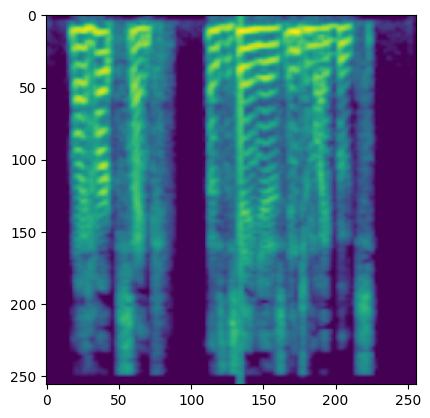

In [66]:
input_data_2d = np.squeeze(create_input(REAL_DIR+'/DF_E_2000053.wav'))
plt.imshow(input_data_2d)

### test loaded models

In [74]:
input_data =  create_input(FAKE_DIR+'/DF_E_2000011.wav')

### predict 

In [75]:
predictions = undersp_model.predict(input_data)

# Print the predictions
print("Predicted probabilities:", predictions)

# For binary classification
predicted_label = (predictions > 0.5).astype(int)
print("Predicted label:", predicted_label)

1/1 [==============================] - 0s 21ms/step
Predicted probabilities: [[0.9948428]]
Predicted label: [[1]]


### load wavefake dataset